In [2]:
# set brainpy
# "pip install brainpy==2.4.4" , my version is 2.4.4
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd
import os

bm.enable_x64()
bm.set_platform('cpu')
# test version
bp.__version__

'2.4.4'

In [3]:
# define Exponential synapse
class Exponential(bp.Projection):
    def __init__(self, pre, post, prob, g_max, tau, E=0.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPostMg2(
            pre=pre,
            delay=None, 
            comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
            syn=bp.dyn.Expon.desc(post.num, tau=tau),
            out=bp.dyn.COBA.desc(E=E),
            post=post,
        )

In [8]:
# define RGC to O1&O2 network
# SO-A RGC number = 10/462*3500 ≈ 75
# SGC/SAC-P RGC = 13/462*3500 ≈ 100
# realistic, 
# TPN-E number = 223/945*10700 ≈ 2525      
# TPN-O number = 62/945*10700 ≈ 690      
# but here we set model all 300
# M-cell = 2
# nMLF ≈ 20-60
class R2O(bp.DynSysGroup):
    def __init__(self, num_rgc_so, num_rgc_sg, num_tpn_e, num_tpn_o, num_mcell, num_nmlf, method='exp_auto'):
        super().__init__()

        # neurons
        pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                    V_initializer=bp.init.Normal(-55., 2.), method=method)
        self.rgc_so = bp.dyn.LifRef(num_rgc_so, **pars)
        self.rgc_sg = bp.dyn.LifRef(num_rgc_sg, **pars)
        self.tpn_e = bp.dyn.LifRef(num_tpn_e, **pars)
        self.tpn_o = bp.dyn.LifRef(num_tpn_o, **pars)

        pars1 = dict(V_rest=-63., V_th=-50., V_reset=-62., tau=20., tau_ref=10.,
                     V_initializer=bp.init.Normal(-55., 2.), method=method)
        pars2 = dict(V_rest=-60., V_th=-50., V_reset=-62., tau=20., tau_ref=5.,
                     V_initializer=bp.init.Normal(-55., 2.), method=method)        
        self.mcell = bp.dyn.LifRef(num_mcell, **pars1)
        self.nmlf = bp.dyn.LifRef(num_nmlf, **pars2)


        # Neurons connect to each other randomly with a connection probability of 2%
        self.ro2tpn_o = Exponential(self.rgc_so, self.tpn_o, 0.056, g_max=0.6, tau=5., E=0.)
        self.ro2tpn_e = Exponential(self.rgc_so, self.tpn_e, 0.009, g_max=0.6, tau=5., E=0.)
        self.rg2tpn_o = Exponential(self.rgc_sg, self.tpn_o, 0.001, g_max=0.6, tau=5., E=0.)
        self.rg2tpn_e = Exponential(self.rgc_sg, self.tpn_e, 0.079, g_max=0.6, tau=5., E=0.)
        self.tpn_o2nmlf = Exponential(self.tpn_o, self.nmlf, 0.254, g_max=0.6, tau=5., E=0.)
        self.tpn_e2mcell = Exponential(self.tpn_e, self.mcell, 0.457, g_max=0.6, tau=5., E=0.)

    
    def update(self, inp):
        self.rgc_so(inp)  # SO-A RGC receive the external input
        self.rgc_sg()
        self.tpn_e()
        self.tpn_o()
        self.ro2tpn_o()
        self.ro2tpn_e()
        self.rg2tpn_o()
        self.rg2tpn_e()
        self.mcell()
        self.nmlf()
        self.tpn_o2nmlf()
        self.tpn_e2mcell()


class R2E(bp.DynSysGroup):
    def __init__(self, num_rgc_so, num_rgc_sg, num_tpn_e, num_tpn_o, num_mcell, num_nmlf, method='exp_auto'):
        super().__init__()

        # neurons
        pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                    V_initializer=bp.init.Normal(-55., 2.), method=method)
        self.rgc_so = bp.dyn.LifRef(num_rgc_so, **pars)
        self.rgc_sg = bp.dyn.LifRef(num_rgc_sg, **pars)
        self.tpn_e = bp.dyn.LifRef(num_tpn_e, **pars)
        self.tpn_o = bp.dyn.LifRef(num_tpn_o, **pars)

        pars1 = dict(V_rest=-62., V_th=-50., V_reset=-62., tau=20., tau_ref=5.,
                     V_initializer=bp.init.Normal(-55., 2.), method=method)
        pars2 = dict(V_rest=-60., V_th=-50., V_reset=-62., tau=20., tau_ref=5.,
                     V_initializer=bp.init.Normal(-55., 2.), method=method)        
        self.mcell = bp.dyn.LifRef(num_mcell, **pars1)
        self.nmlf = bp.dyn.LifRef(num_nmlf, **pars2)


        # Neurons connect to each other randomly with a connection probability of 2%
        self.ro2tpn_o = Exponential(self.rgc_so, self.tpn_o, 0.056, g_max=0.6, tau=5., E=0.)
        self.ro2tpn_e = Exponential(self.rgc_so, self.tpn_e, 0.009, g_max=0.6, tau=5., E=0.)
        self.rg2tpn_o = Exponential(self.rgc_sg, self.tpn_o, 0.001, g_max=0.6, tau=5., E=0.)
        self.rg2tpn_e = Exponential(self.rgc_sg, self.tpn_e, 0.079, g_max=0.6, tau=5., E=0.)
        self.tpn_o2nmlf = Exponential(self.tpn_o, self.nmlf, 0.254, g_max=0.6, tau=5., E=0.)
        self.tpn_e2mcell = Exponential(self.tpn_e, self.mcell, 0.914, g_max=0.6, tau=3., E=0.)

    
    def update(self, inp):
        self.rgc_sg(inp)  # SGC/SAC-P RGC receive the external input
        self.rgc_so()
        self.tpn_e()
        self.tpn_o()
        self.ro2tpn_o()
        self.ro2tpn_e()
        self.rg2tpn_o()
        self.rg2tpn_e()
        self.mcell()
        self.nmlf()
        self.tpn_o2nmlf()
        self.tpn_e2mcell()

net_R2O = R2O(75, 100, 2525, 690, 2, 40)
net_R2E = R2E(75, 100, 2525, 690, 2, 40)

  0%|          | 0/1000 [00:00<?, ?it/s]

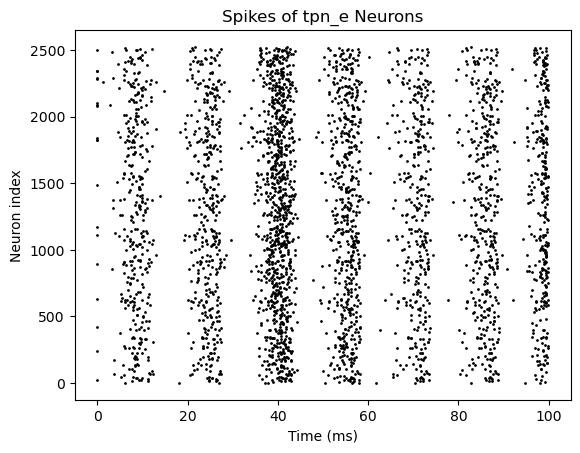

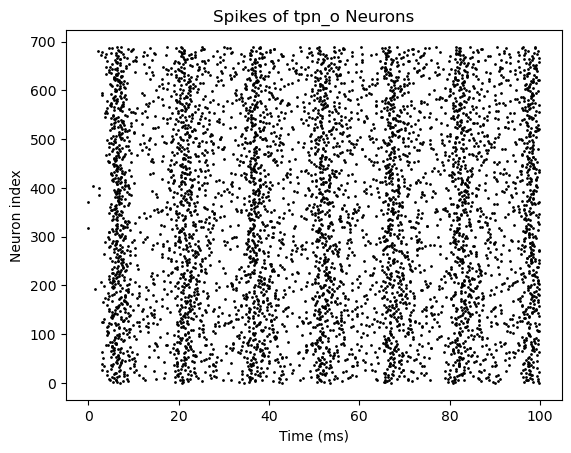

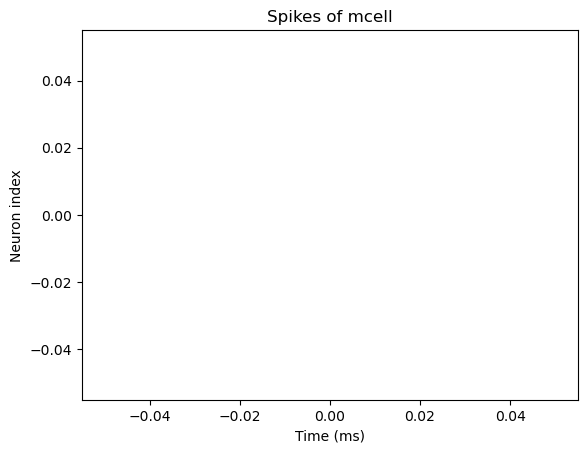

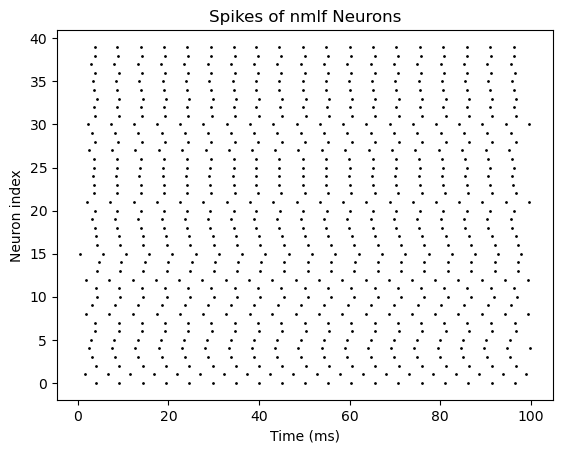

In [9]:
# running the network
inputs = np.ones(int(100. / bm.get_dt())) * 25.  # 100 ms, with the same current of 20
runner = bp.DSRunner(net_R2O, monitors=['rgc_so.spike','rgc_sg.spike', 'tpn_e.spike', 'tpn_o.spike', 'mcell.spike', 'nmlf.spike','rgc_so.V', 'tpn_e.V', 'tpn_o.V', 'mcell.V', 'nmlf.V'])
runner.run(inputs=inputs)

# visualization raster


bp.visualize.raster_plot(runner.mon.ts, runner.mon['tpn_e.spike'],
                         title='Spikes of tpn_e Neurons',show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['tpn_o.spike'],
                         title='Spikes of tpn_o Neurons',show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['mcell.spike'],
                         title='Spikes of mcell',show=True)
plt.savefig('F2b1.png', dpi=1200)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['nmlf.spike'],
                         title='Spikes of nmlf Neurons')

plt.savefig('F2b2.png', dpi=1200)

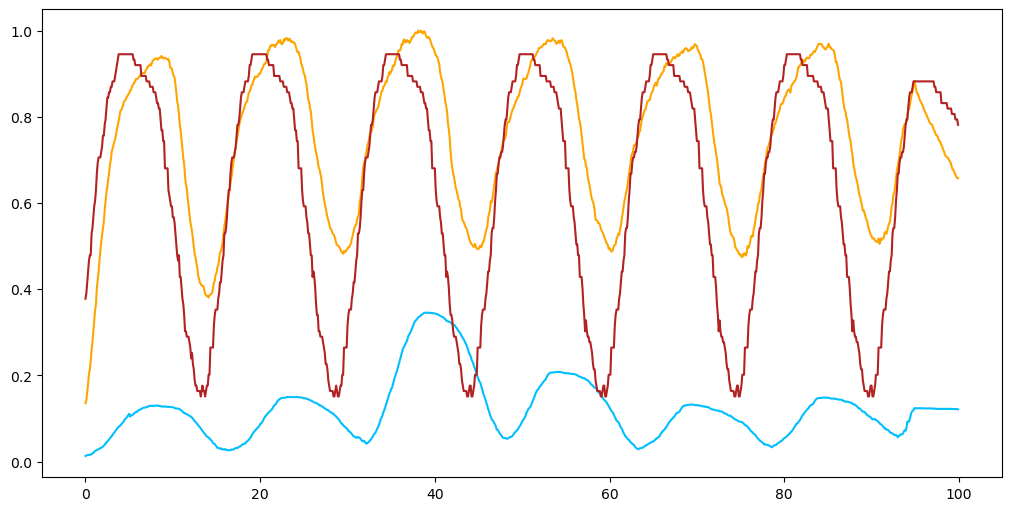

In [10]:
# measure firing rate
fig, gs = bp.visualize.get_figure(1, 1, 5, 10)
rate1 = bp.measure.firing_rate(runner.mon['tpn_e.spike'], width=10.)
rate2 = bp.measure.firing_rate(runner.mon['tpn_o.spike'], width=10.)
rate3 = bp.measure.firing_rate(runner.mon['rgc_so.spike'], width=10.)


max_val = max(rate2)

# visualization
plt.plot(runner.mon['ts'], rate1/max_val, label="Group O1", color='deepskyblue')
plt.plot(runner.mon['ts'], rate2/max_val, label="Group O2", color='orange')
plt.plot(runner.mon['ts'], rate3/max_val, color='firebrick')


# # 保存图表到文件
# plt.savefig('F2b3.pdf')
# plt.show()

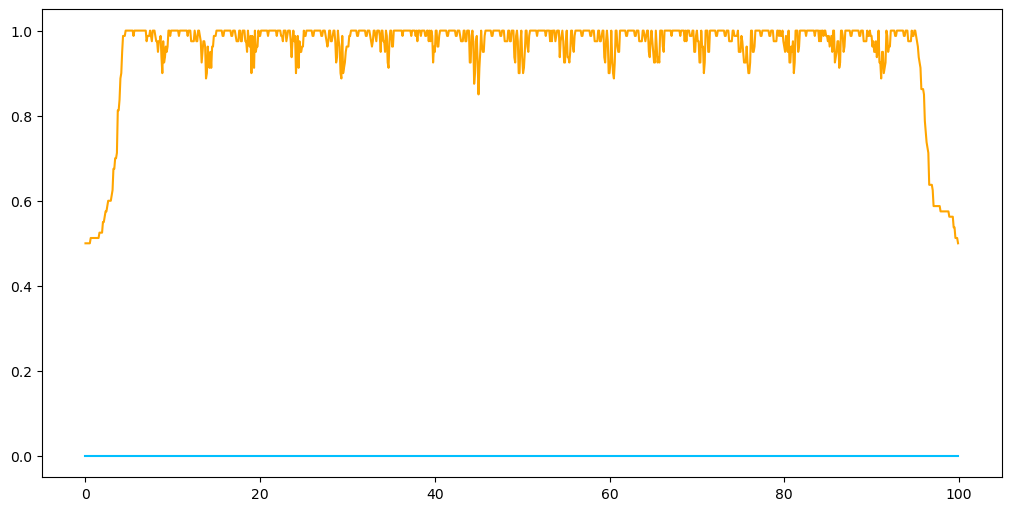

In [11]:
# measure firing rate
fig, gs = bp.visualize.get_figure(1, 1, 5, 10)
rate1 = bp.measure.firing_rate(runner.mon['mcell.spike'], width=10.)
rate2 = bp.measure.firing_rate(runner.mon['nmlf.spike'], width=10.)



max_val = max(rate2)

# visualization
plt.plot(runner.mon['ts'], rate1/max_val, label="Group O1", color='deepskyblue')
plt.plot(runner.mon['ts'], rate2/max_val, label="Group O2", color='orange')



# # 保存图表到文件
# plt.savefig('F2b4.png', dpi=1200)
# plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

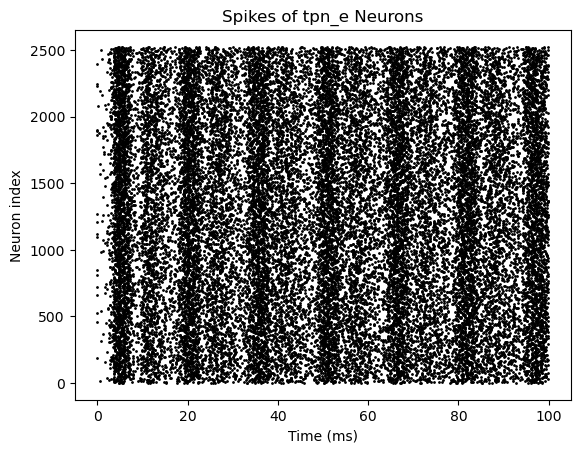

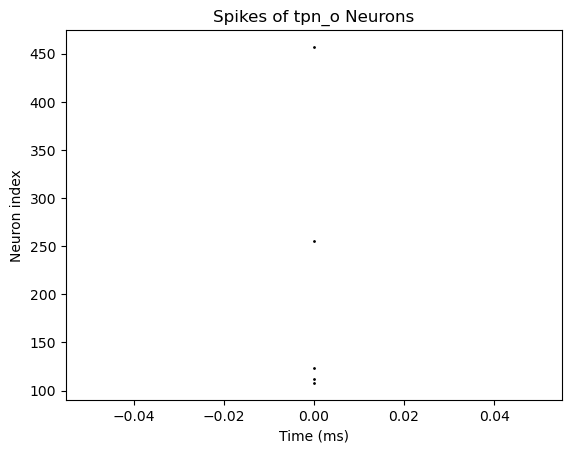

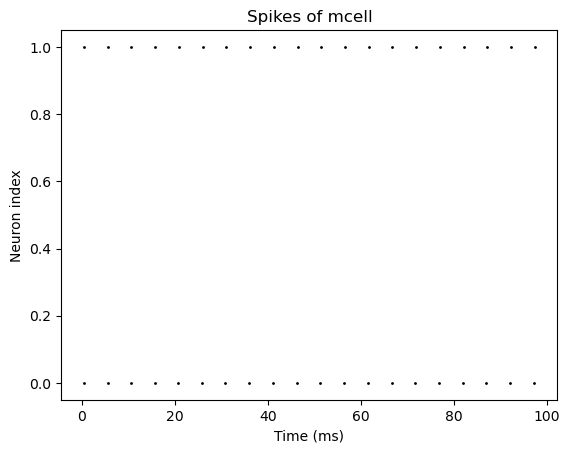

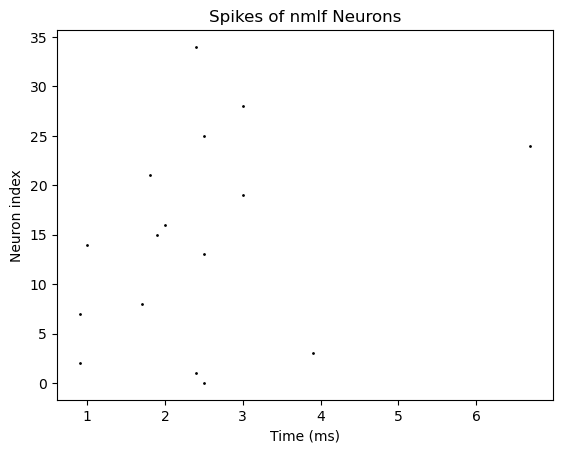

In [12]:
# running the network
inputs = np.ones(int(100. / bm.get_dt())) * 25.  # 100 ms, with the same current of 20
runner = bp.DSRunner(net_R2E, monitors=['rgc_so.spike','rgc_sg.spike', 'tpn_e.spike', 'tpn_o.spike', 'mcell.spike', 'nmlf.spike','rgc_so.V', 'tpn_e.V', 'tpn_o.V', 'mcell.V', 'nmlf.V'])
runner.run(inputs=inputs)

# visualization raster



bp.visualize.raster_plot(runner.mon.ts, runner.mon['tpn_e.spike'],
                         title='Spikes of tpn_e Neurons',show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['tpn_o.spike'],
                         title='Spikes of tpn_o Neurons',show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['mcell.spike'],
                         title='Spikes of mcell',show=True)
plt.savefig('F2b11.png', dpi=1200)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['nmlf.spike'],
                         title='Spikes of nmlf Neurons')

# plt.savefig('F2b12.png', dpi=1200)

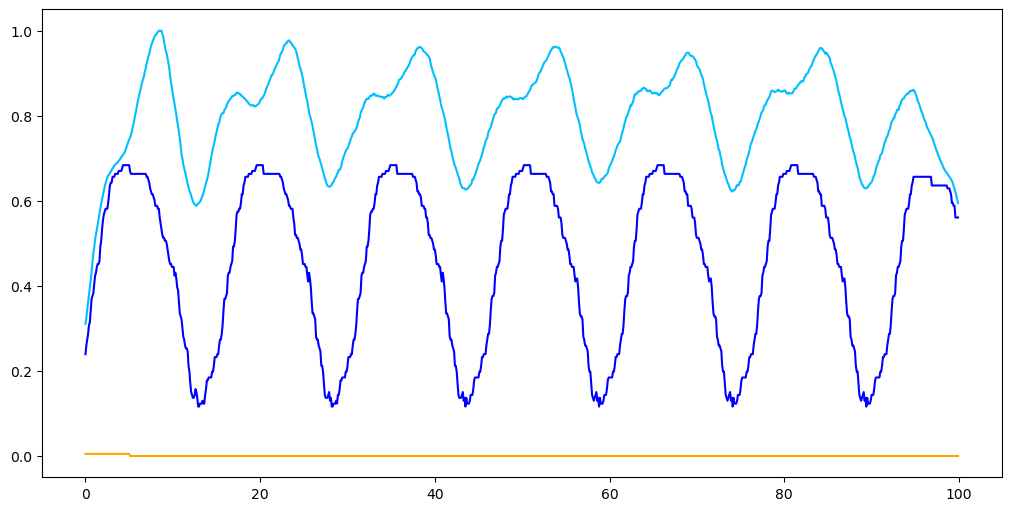

In [13]:
# measure firing rate
fig, gs = bp.visualize.get_figure(1, 1, 5, 10)
rate1 = bp.measure.firing_rate(runner.mon['tpn_e.spike'], width=10.)
rate2 = bp.measure.firing_rate(runner.mon['tpn_o.spike'], width=10.)
rate3 = bp.measure.firing_rate(runner.mon['rgc_sg.spike'], width=10.)


max_val = max(rate1)

# visualization
plt.plot(runner.mon['ts'], rate1/max_val, label="Group O1", color='deepskyblue')
plt.plot(runner.mon['ts'], rate2/max_val, label="Group O2", color='orange')
plt.plot(runner.mon['ts'], rate3/max_val, color='b')


# 保存图表到文件
# plt.savefig('F2b6.pdf')
plt.show()

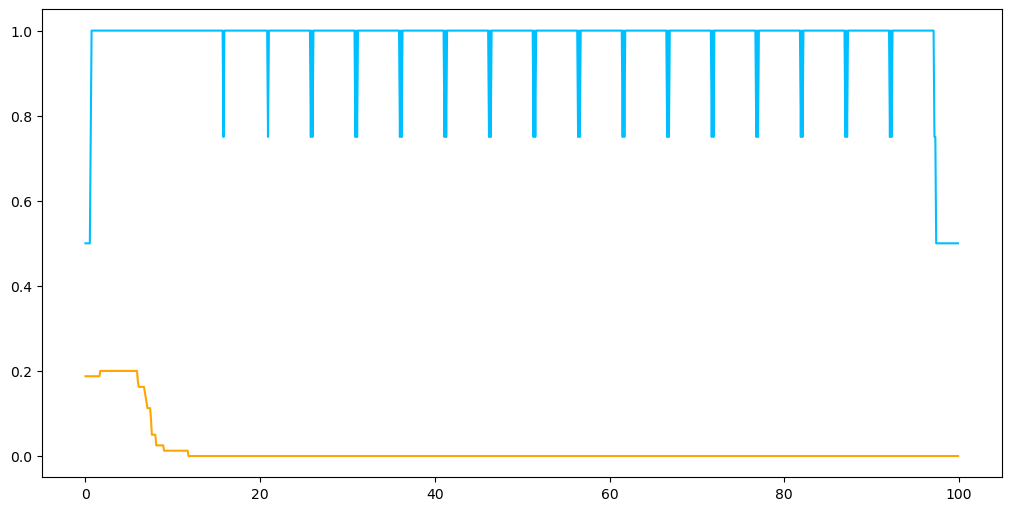

In [14]:
# measure firing rate
fig, gs = bp.visualize.get_figure(1, 1, 5, 10)
rate1 = bp.measure.firing_rate(runner.mon['mcell.spike'], width=10.)
rate2 = bp.measure.firing_rate(runner.mon['nmlf.spike'], width=10.)


max_val = max(rate1)

# visualization
plt.plot(runner.mon['ts'], rate1/max_val, label="Group O1", color='deepskyblue')
plt.plot(runner.mon['ts'], rate2/max_val, label="Group O2", color='orange')



# 保存图表到文件
# plt.savefig('F2b7.png', dpi=1200)
plt.show()